In [1]:
import os
import cx_Oracle
import pandas as pd
import numpy as np
import pickle
from datetime import date,datetime
from sklearn import metrics
from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV, cross_val_score 
import time
import matplotlib.pyplot as plt
from sklearn.utils import resample
import datetime

In [2]:
#connection = cx_Oracle.connect('HCIN_GUPTAN1[AP_UWI]/aGqQ4jnX92NG@INCL02.IN.PROD/HWIN_USR_DEV.HOMECREDIT.IN')
#cursor = connection.cursor()
#os.chdir(r"C:\Users\aman.khatri91425\Desktop\HomeCredit\Bigdata\Common Maps KNN")
# qu1= """
# select * from TMP_BD_GRID_DISTANCE_ID_NEW
# where risk_agrf120 =1 
# """
#df = pd.read_sql(qu1,connection)
#df.to_pickle(r"C:\Users\aman.khatri91425\Desktop\HomeCredit\Bigdata\Common Maps KNN\data_dump_new_grids.pkl")
#df.to_csv(r"C:\Users\aman.khatri91425\Desktop\HomeCredit\Bigdata\Common Maps KNN\data_dump_new_grids.csv")

In [2]:
df = pd.read_pickle(r"C:\Users\aman.khatri91425\Desktop\HomeCredit\Bigdata\Common Maps KNN\data_dump_new_grids.pkl")

In [3]:
df.head()

,SKP_CREDIT_CASE,TIME_DECISION_DATE,CUS_LAT,CUS_LONG,RISK_FSTQPD30,RISK_AGRF120,PRODUCT_GROUP,CLIENT_EXI_3M,RISK_SCORE,RNK
0,96741638,2017-01-01,18.554284,73.920496,0,1,CD,N,NaN,1
1,96904701,2017-01-01,18.490897,73.810959,0,1,CD,N,NaN,1
2,96906113,2017-01-02,28.502912,77.332831,0,1,CD,N,NaN,1
3,96909346,2017-01-03,18.950583,72.828613,0,1,CD,N,NaN,1
4,96910547,2017-01-01,32.239398,77.192587,0,1,CD,N,NaN,1


In [4]:
df.dropna(subset = ["RISK_SCORE"], inplace = True)

In [5]:
df["MONTH_STR"] = df["TIME_DECISION_DATE"].dt.strftime("%Y-%m")
df_summ = df[["MONTH_STR","RISK_FSTQPD30"]].groupby("MONTH_STR").aggregate(["count","sum"])["RISK_FSTQPD30"]
df_summ["bad_rate"] = df_summ["sum"]/df_summ["count"]

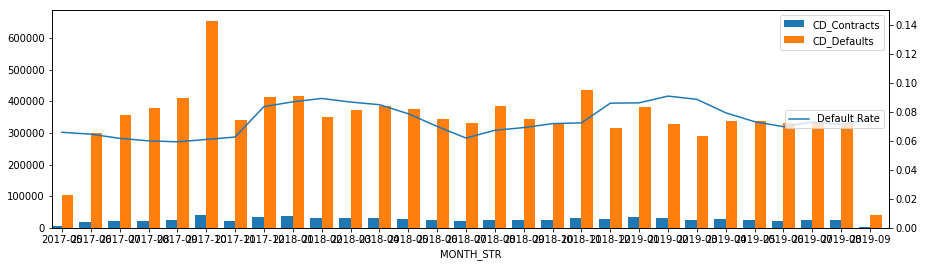

In [6]:
df_summ[['sum','count']].plot(kind='bar', width = 0.8, figsize=(15,4))
df_summ['bad_rate'].plot(secondary_y=True)

ax = plt.gca()
plt.xlim([-0.35, len(df_summ['sum'])-0.35])
ax.set_xticklabels(df_summ.index)
plt.ylim
fig = ax.get_figure()
ax = fig.get_axes()
ax[1].set_ylim(0,0.15)
ax[0].legend(['CD_Contracts','CD_Defaults'])
ax[1].legend(["Default Rate"], loc = "center right")


plt.show()


In [14]:
df_final_test = pd.DataFrame()

import datetime
from sklearn.neighbors import KNeighborsClassifier

for x in np.arange(1,8,1):
    
    date_test_start = datetime.datetime(2019, x, 1)
    date_test_end = (date_test_start +  datetime.timedelta(days=31)).replace(day=1)
    date_train_start = (date_test_start-datetime.timedelta(days=120)-datetime.timedelta(days=365)) 
    date_train_end = (date_test_start-datetime.timedelta(days=120))

    
    
    start_time = datetime.datetime.now()
    df_train = df[(df["TIME_DECISION_DATE"]>=date_train_start) & 
              (df["TIME_DECISION_DATE"]<date_train_end)]
    df_test = df[(df["TIME_DECISION_DATE"]>=date_test_start) & 
                  (df["TIME_DECISION_DATE"]<date_test_end)]


    count_class_0, count_class_1 = df_train.RISK_FSTQPD30.value_counts()
    df_class_0 = df_train[df_train['RISK_FSTQPD30'] == 0]
    df_class_1 = df_train[df_train['RISK_FSTQPD30'] == 1]
    df_class_0_under = df_class_0.sample(200000)
    df_class_1_under = df_class_1.sample(200000)
    df_train_under = pd.concat([df_class_0_under, df_class_1_under], axis=0)

    X_train = df_train_under[["CUS_LAT","CUS_LONG","RISK_SCORE","TIME_DECISION_DATE"]]
    X_test = df_test[["CUS_LAT","CUS_LONG","RISK_SCORE","TIME_DECISION_DATE"]]

    y_train = df_train_under["RISK_FSTQPD30"]
    y_test =  df_test["RISK_FSTQPD30"]



    knn = KNeighborsClassifier(n_neighbors = 400)
    bst = knn.fit(X_train[["CUS_LAT","CUS_LONG"]], np.ravel(y_train))

    ypred_train = bst.predict_proba(X_train[["CUS_LAT","CUS_LONG"]])[:, 1]
    ypred_test = bst.predict_proba(X_test[["CUS_LAT","CUS_LONG"]])[:, 1]

    metric_auc_train = metrics.roc_auc_score(y_train, ypred_train)
    metric_auc_test = metrics.roc_auc_score(y_test, ypred_test)

    gini_train = 2 * metric_auc_train - 1
    gini_test = 2 * metric_auc_test - 1

    
    df_test['PRED_SCORE'] = ypred_test
    
    if df_final_test.shape == (0,0):
        df_final_test = df_test
    else:
        df_final_test = pd.concat([df_final_test,df_test],ignore_index=True)

    print("Training for predicting (month):",date_test_start.month, "    GINI TRAIN:",'{:,.2%}'.format(gini_train), "    GINI TEST:",'{:,.2%}'.format(gini_test),
         "    time taken: ",'{:,.2}'.format((datetime.datetime.now()-start_time).seconds/60))




C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Training for predicting (month): 9     GINI TRAIN: 14.93%     GINI TEST: 10.88%     time taken:  1.5


C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Training for predicting (month): 10     GINI TRAIN: 14.95%     GINI TEST: 11.01%     time taken:  1.4


C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Training for predicting (month): 11     GINI TRAIN: 14.86%     GINI TEST: 10.76%     time taken:  1.3


C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Training for predicting (month): 12     GINI TRAIN: 14.87%     GINI TEST: 10.44%     time taken:  1.4


C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Training for predicting (month): 1     GINI TRAIN: 15.00%     GINI TEST: 10.26%     time taken:  1.4


C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Training for predicting (month): 2     GINI TRAIN: 14.57%     GINI TEST: 8.99%     time taken:  1.4


C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Training for predicting (month): 3     GINI TRAIN: 14.84%     GINI TEST: 8.44%     time taken:  1.4


In [10]:
df_final_test.head()

,SKP_CREDIT_CASE,TIME_DECISION_DATE,CUS_LAT,CUS_LONG,RISK_FSTQPD30,RISK_AGRF120,PRODUCT_GROUP,CLIENT_EXI_3M,RISK_SCORE,RNK,MONTH_STR,PRED_SCORE
0,219906800,2019-01-01,18.637497,73.836025,0,1,CD,N,0.020050,1,2019-01,0.4050
1,219993472,2019-01-01,23.194511,77.462190,0,1,CD,N,0.021875,1,2019-01,0.4775
2,220005765,2019-01-01,19.155484,72.845582,0,1,CD,Y,0.010981,1,2019-01,0.4875
3,220099958,2019-01-01,28.504690,77.231656,1,1,CD,N,0.020797,1,2019-01,0.5025
4,220101732,2019-01-02,18.635453,73.792278,0,1,CD,N,0.008695,1,2019-01,0.5275


In [17]:
date_train_end

datetime.datetime(2019, 3, 3, 0, 0)

In [18]:
df_final_test["LOGIT_RISK_SCORE"] = [np.log(x/(1-x)) for x in df_final_test["RISK_SCORE"]]
df_final_test["LOGIT_PRED_SCORE"] = [np.log(x/(1-x)) for x in df_final_test["PRED_SCORE"]]

In [34]:
df_combined_score=df_final_test[['LOGIT_RISK_SCORE','LOGIT_PRED_SCORE','RISK_FSTQPD30'
                                 ,'SKP_CREDIT_CASE', 'TIME_DECISION_DATE']][df_final_test["TIME_DECISION_DATE"]<=datetime.datetime(2019, 1, 31)]

In [36]:
#Calculate Gini Lift Logistic Regression
from sklearn.linear_model import LogisticRegression
comb=LogisticRegression()
comb.fit(df_combined_score[['LOGIT_RISK_SCORE','LOGIT_PRED_SCORE']],df_combined_score["RISK_FSTQPD30"])

C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [46]:
print(comb.intercept_)
print(comb.coef_)



[0.46478655]
[[0.63516046 0.58340657]]


In [44]:
df_final_test["COMBINED_SCORE"]= 1/(1+np.exp(-(df_final_test["LOGIT_RISK_SCORE"]*0.63516046+ 
              df_final_test["LOGIT_PRED_SCORE"]*0.58340657 + 0.46478655)))

In [45]:

print("GINI COMBINED: ",'{:,.2%}'.format(2 * metrics.roc_auc_score(df_final_test["RISK_FSTQPD30"], df_final_test["COMBINED_SCORE"]) - 1))
print("GINI HC: ",'{:,.2%}'.format(2 * metrics.roc_auc_score(df_final_test["RISK_FSTQPD30"], df_final_test["RISK_SCORE"]) - 1))
print("GINI KNN: ",'{:,.2%}'.format(2 * metrics.roc_auc_score(df_final_test["RISK_FSTQPD30"], df_final_test["PRED_SCORE"]) - 1))


GINI COMBINED:  26.47%
GINI HC:  25.03%
GINI KNN:  10.21%


In [23]:
df_final_test.head()

,SKP_CREDIT_CASE,TIME_DECISION_DATE,CUS_LAT,CUS_LONG,RISK_FSTQPD30,RISK_AGRF120,PRODUCT_GROUP,CLIENT_EXI_3M,RISK_SCORE,RNK,MONTH_STR,PRED_SCORE,LOGIT_RISK_SCORE,LOGIT_PRED_SCORE,COMBINED_SCORE
0,219906800,2019-01-01,18.637497,73.836025,0,1,CD,N,0.020050,1,2019-01,0.3925,-3.889290,-0.436816,0.119715
1,219993472,2019-01-01,23.194511,77.462190,0,1,CD,N,0.021875,1,2019-01,0.4700,-3.800296,-0.120144,0.152652
2,220005765,2019-01-01,19.155484,72.845582,0,1,CD,Y,0.010981,1,2019-01,0.4575,-4.500573,-0.170411,0.093388
3,220099958,2019-01-01,28.504690,77.231656,1,1,CD,N,0.020797,1,2019-01,0.5000,-3.851954,0.000000,0.158251
4,220101732,2019-01-02,18.635453,73.792278,0,1,CD,N,0.008695,1,2019-01,0.5275,-4.736259,0.110111,0.094521


In [ ]:
df_final_test["MONTH_STR"] = df_final_test["TIME_DECISION_DATE"].dt.strftime("%Y-%m")

In [48]:
#MOM Gini
#Month on Month Gini
df=df_final_test
RISK_SCORE = "RISK_SCORE"

import sys
sys.path.append(R'C:\Users\aman.khatri91425\Desktop\HomeCredit\Bigdata\Scoring Worlflow')
from scoring.metrics import iv,gini,lift

power_tab = []
for j in df["MONTH_STR"].unique():
    power_tab.append({'Name':j
#                    ,'IV':iv(df.loc[(df['MONTH_STR']==j) & (df['FOUND_FLAG']==1),"RISK_FSTPD30"], df.loc[(df['MONTH_STR']==j) & (df['FOUND_FLAG']==1),"YPRED"])
                    ,'Gini_HC':gini(df.loc[(df['MONTH_STR']==j),"RISK_FSTQPD30"], df.loc[(df['MONTH_STR']==j),RISK_SCORE])
                    ,'Gini_HC_EXI':gini(df.loc[(df['MONTH_STR']==j) & (df['CLIENT_EXI_3M']=='Y'),"RISK_FSTQPD30"], df.loc[(df['MONTH_STR']==j) & (df['CLIENT_EXI_3M']=='Y'),RISK_SCORE])
                    ,'Gini_HC_NEW':gini(df.loc[(df['MONTH_STR']==j) & (df['CLIENT_EXI_3M']=='N'),"RISK_FSTQPD30"], df.loc[(df['MONTH_STR']==j) & (df['CLIENT_EXI_3M']=='N'),RISK_SCORE])
                    
                    ,'Gini_KNN':gini(df.loc[(df['MONTH_STR']==j),"RISK_FSTQPD30"], df.loc[(df['MONTH_STR']==j),"PRED_SCORE"])
                    ,'Gini_KNN_EXI':gini(df.loc[(df['MONTH_STR']==j) & (df['CLIENT_EXI_3M']=='Y'),"RISK_FSTQPD30"], df.loc[(df['MONTH_STR']==j) & (df['CLIENT_EXI_3M']=='Y'),"PRED_SCORE"])
                    ,'Gini_KNN_NEW':gini(df.loc[(df['MONTH_STR']==j) & (df['CLIENT_EXI_3M']=='N'),"RISK_FSTQPD30"], df.loc[(df['MONTH_STR']==j) & (df['CLIENT_EXI_3M']=='N'),"PRED_SCORE"])
                    
                    ,'Gini_COMB':gini(df.loc[(df['MONTH_STR']==j),"RISK_FSTQPD30"], df.loc[(df['MONTH_STR']==j),"COMBINED_SCORE"])
                    ,'Gini_COMB_EXI':gini(df.loc[(df['MONTH_STR']==j) & (df['CLIENT_EXI_3M']=='Y'),"RISK_FSTQPD30"], df.loc[(df['MONTH_STR']==j) & (df['CLIENT_EXI_3M']=='Y'),"COMBINED_SCORE"])
                    ,'Gini_COMB_NEW':gini(df.loc[(df['MONTH_STR']==j) & (df['CLIENT_EXI_3M']=='N'),"RISK_FSTQPD30"], df.loc[(df['MONTH_STR']==j) & (df['CLIENT_EXI_3M']=='N'),"COMBINED_SCORE"])
                    
                      #                    ,'Lift':lift(df.loc[(df['MONTH_STR']==j) & (df['FOUND_FLAG']==1),"RISK_FSTPD30"], df.loc[(df['MONTH_STR']==j) & (df['FOUND_FLAG']==1),"YPRED"])
                         })
    
power_out = pd.DataFrame.from_records(power_tab)
power_out = power_out.set_index('Name')
power_out = power_out.sort_values('Name',ascending=True)

pd.options.display.max_rows = 1000
display(power_out)
pd.options.display.max_rows = 15
power_out.to_csv(r"C:\Users\aman.khatri91425\Desktop\HomeCredit\Bigdata\Common Maps KNN\mom_hc_found_gini_all_scores.csv")

[{'Name': '2019-01', 'Gini_HC': 0.24246876682873064, 'Gini_HC_EXI': 0.33175607499139614, 'Gini_HC_NEW': 0.2304746196109515, 'Gini_KNN': 0.10884503708332138, 'Gini_KNN_EXI': 0.09582222283522324, 'Gini_KNN_NEW': 0.10294926534614413, 'Gini_COMB': 0.25830088030980125, 'Gini_COMB_EXI': 0.33443610267674684, 'Gini_COMB_NEW': 0.24514573551638819}]
[{'Name': '2019-01', 'Gini_HC': 0.24246876682873064, 'Gini_HC_EXI': 0.33175607499139614, 'Gini_HC_NEW': 0.2304746196109515, 'Gini_KNN': 0.10884503708332138, 'Gini_KNN_EXI': 0.09582222283522324, 'Gini_KNN_NEW': 0.10294926534614413, 'Gini_COMB': 0.25830088030980125, 'Gini_COMB_EXI': 0.33443610267674684, 'Gini_COMB_NEW': 0.24514573551638819}, {'Name': '2019-02', 'Gini_HC': 0.250222726189278, 'Gini_HC_EXI': 0.316780183857994, 'Gini_HC_NEW': 0.2441480635451203, 'Gini_KNN': 0.1100581719398801, 'Gini_KNN_EXI': 0.09510767862359426, 'Gini_KNN_NEW': 0.10487097924375988, 'Gini_COMB': 0.2657949949789149, 'Gini_COMB_EXI': 0.31854748265865074, 'Gini_COMB_NEW': 0.2

[{'Name': '2019-01', 'Gini_HC': 0.24246876682873064, 'Gini_HC_EXI': 0.33175607499139614, 'Gini_HC_NEW': 0.2304746196109515, 'Gini_KNN': 0.10884503708332138, 'Gini_KNN_EXI': 0.09582222283522324, 'Gini_KNN_NEW': 0.10294926534614413, 'Gini_COMB': 0.25830088030980125, 'Gini_COMB_EXI': 0.33443610267674684, 'Gini_COMB_NEW': 0.24514573551638819}, {'Name': '2019-02', 'Gini_HC': 0.250222726189278, 'Gini_HC_EXI': 0.316780183857994, 'Gini_HC_NEW': 0.2441480635451203, 'Gini_KNN': 0.1100581719398801, 'Gini_KNN_EXI': 0.09510767862359426, 'Gini_KNN_NEW': 0.10487097924375988, 'Gini_COMB': 0.2657949949789149, 'Gini_COMB_EXI': 0.31854748265865074, 'Gini_COMB_NEW': 0.259227351921542}, {'Name': '2019-03', 'Gini_HC': 0.2628918645375553, 'Gini_HC_EXI': 0.3380747401117843, 'Gini_HC_NEW': 0.25596210083026194, 'Gini_KNN': 0.10761399482467793, 'Gini_KNN_EXI': 0.10063442717631266, 'Gini_KNN_NEW': 0.09994071673187177, 'Gini_COMB': 0.2772905488782622, 'Gini_COMB_EXI': 0.34208975131008335, 'Gini_COMB_NEW': 0.268674

,Gini_COMB,Gini_COMB_EXI,Gini_COMB_NEW,Gini_HC,Gini_HC_EXI,Gini_HC_NEW,Gini_KNN,Gini_KNN_EXI,Gini_KNN_NEW
Name,,,,,,,,,
2019-01,0.258301,0.334436,0.245146,0.242469,0.331756,0.230475,0.108845,0.095822,0.102949
2019-02,0.265795,0.318547,0.259227,0.250223,0.316780,0.244148,0.110058,0.095108,0.104871
2019-03,0.277291,0.342090,0.268674,0.262892,0.338075,0.255962,0.107614,0.100634,0.099941
2019-04,0.275002,0.343231,0.263226,0.261432,0.337654,0.251490,0.104366,0.107479,0.095196
2019-05,0.282319,0.364543,0.266299,0.267282,0.361962,0.250793,0.102596,0.089985,0.102414
2019-06,0.250211,0.305681,0.248744,0.236219,0.300783,0.237786,0.089854,0.078185,0.083563
2019-07,0.233194,0.288641,0.236256,0.221132,0.288510,0.225507,0.084355,0.071084,0.079044


In [50]:
df_final_test[["SKP_CREDIT_CASE","PRED_SCORE"]].to_csv(r"C:\Users\aman.khatri91425\Desktop\HomeCredit\Bigdata\Common Maps KNN\upload_scores.csv", index = False)

In [126]:
grid_score = df.groupby("GRID_ID").mean()['PRED_SCORE'].reset_index()
grid_score.columns = ['GRID_ID','MEAN_PRED_SCORE']
grid_score.head()

,GRID_ID,MEAN_PRED_SCORE
0,500_00336_03130,0.430657
1,500_00343_03387,0.474453
2,500_00353_03201,0.435523
3,500_00357_03379,0.476886
4,500_00363_03386,0.479319


In [127]:
df_final = pd.merge(df, grid_score, on = 'GRID_ID')

In [131]:
#Calculate Gini Lift Logistic Regression (p/1-p) transformation on mean grid score

df_final["LOGIT_RISK_SCORE"] = [np.log(x/(1-x)) for x in df_final["RISK_SCORE"]]
df_final["LOGIT_MEAN_PRED_SCORE"] = [np.log(x/(1-x)) for x in df_final["MEAN_PRED_SCORE"]]

from sklearn.linear_model import LogisticRegression
comb=LogisticRegression()
comb.fit(df_final[['LOGIT_RISK_SCORE','LOGIT_MEAN_PRED_SCORE']],df_final["RISK_FSTQPD30"])

y_pred_comb=comb.predict_proba(df_final[['LOGIT_RISK_SCORE','LOGIT_MEAN_PRED_SCORE']])[:,1]

metric_auc_combined = metrics.roc_auc_score(df_final["RISK_FSTQPD30"], y_pred_comb)
metric_auc_knn = metrics.roc_auc_score(df_final["RISK_FSTQPD30"], df_final["MEAN_PRED_SCORE"])
metric_auc_hc = metrics.roc_auc_score(df_final["RISK_FSTQPD30"], df_final["RISK_SCORE"])


gini_combined = 2 * metric_auc_combined - 1
gini_knn = 2 * metric_auc_knn - 1
gini_hc = 2 * metric_auc_hc - 1

print("gini_combined:",'{:,.2%}'.format(gini_combined))
print("\ngini_knn:",'{:,.2%}'.format(gini_knn))
print("\ngini_hc:",'{:,.2%}'.format(gini_hc))

C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


gini_combined: 27.19%

gini_knn: 11.80%

gini_hc: 25.02%


In [134]:
df_final = df_final.drop(columns = 'Unnamed: 0')

In [1]:
df_final.to_pickle(r"C:\Users\aman.khatri91425\Desktop\HomeCredit\Bigdata\Common Maps KNN\Combined_Scores_mean_grid.pkl")

NameError: name 'df_final' is not defined

In [33]:
import gmplot
# For improved table display in the notebook
from IPython.display import display

gmap = gmplot.GoogleMapPlotter(28.4431, 77.073, 10)

# Overlay our datapoints onto the map
gmap.heatmap(df[df["PRODUCT_GROUP"]=="CD"]["CUS_LAT"], df[df["PRODUCT_GROUP"]=="CD"]["CUS_LONG"])

# Generate the heatmap into an HTML file
gmap.draw("cd_all.html")


gmap1 = gmplot.GoogleMapPlotter(28.4431, 77.073, 10)

# Overlay our datapoints onto the map
gmap1.heatmap(df[(df["PRODUCT_GROUP"]=="CD") & (df["RISK_FSTQPD30"] == 1)]["CUS_LAT"], df[(df["PRODUCT_GROUP"]=="CD") & (df["RISK_FSTQPD30"] == 1)]["CUS_LONG"])

# Generate the heatmap into an HTML file
gmap1.draw("cd_default.html")